# Assginment5

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import math
import pickle
import time
import torch.utils.data as data
import random

In [2]:
def unflatten_image(image_list):
    # Unflattening images to 32 x 32 
    new_list = []
    for image in image_list:
        new_list.append(image.reshape(1,32,32))

    return np.array(new_list, dtype=np.float64)

In [3]:
def load_pickle(path):
    # Loading pickle datas that are given
    with open(path, 'rb') as fo:
        data = pickle.load(fo)

    data = unflatten_image(data)
    return data

In [4]:
def normalize(imgs):
    # normalizing images between 0 to 1
    new_images = []
    for i in imgs:
        norm = (i - np.min(i)) / (np.max(i) - np.min(i))
        new_images.append(norm)

    return np.array(new_images, dtype=np.float64)

In [5]:
class FaceDataset(data.Dataset):
    # Making an torch dataset using the givne datas
    def __init__(self, image_list, label_list):
        self.images = image_list
        self.labels = label_list

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]

        return img, label

In [6]:
def make_layers(cfg, size):
    # Making the layer of the CNN model 
    # Using the parameters given in the assignment pdf file
    layers = []
    in_channels = 1

    for v in cfg:
        # If the configuration element is 'M' then it menas maxpooling
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            # Adding a convolution layer and ReLU
            conv2d = nn.Conv2d(in_channels, v, kernel_size=size, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            # The input channel has to be updated to output channel
            in_channels = v
    # Returning the layers in sequential
    return nn.Sequential(*layers)

def make_ffn(cfg, size):
    # Makin a fully connected layer at the last part of the CNN model for classification
    input_size = 32 # The size of the image
    channel_size = cfg[0]   # The channel size given from the pdf file
    
    # Calculating the final shape of the input data
    for v in cfg:
        if v == 'M':
            input_size = math.floor(input_size/2)

        else:
            input_size = math.floor(input_size-size+3)


    # Returning the fully connected layer for classification
    return nn.Linear(channel_size * input_size * input_size, 2)

class CNN(nn.Module):
    def __init__(self, cfg, size):
        super().__init__()
        # Adding the layers via configs
        self.features = make_layers(cfg, size)
        # Adding the fully connected layer
        self.fc_layer = make_ffn(cfg, size)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flattening the input datas as [batch_size, height*width*channel]
        x = self.fc_layer(x)
        return x
    

In [7]:
def train_model(net, train_loader, criterion, optimizer, num_epochs):

    # Using GPU if there is a gpu and it can use cuda
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    net.to(device)
    
    loss_arr = []
    start = time.time()
    net.train()
    
    # Iterating number epochs
    for _ in range(num_epochs):

        epoch_loss = 0.0
        
        for data, target in train_loader:
            data, target = data.to(device).float(), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # Adding every loss in the current epoch
            epoch_loss += loss.item() * data.size(0)

        # Calculating the epoch from the current epoch
        epoch_loss = epoch_loss / len(train_loader.dataset)
        # Appending the epoch loss in the array
        loss_arr.append(epoch_loss)

    training_time = time.time() - start


    return loss_arr, training_time

In [8]:
def evaluate(net, test_loader):

    # Using GPU if there is a gpu and it can use cuda
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    net.to(device)
    net.eval()
    
    # counting the correct answers
    correct = 0

    # no gradients needed
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device).float(), target.to(device)
            output = net(data)

            _, preds = torch.max(output, 1)
            
            # Calculating the total correct prediction
            correct += torch.sum(preds == target.data)

    # Calculating the accuracy of the model
    acc = correct / len(test_loader.dataset) * 100

    return acc

In [9]:
def experiment(train_loader, test_loader):
    """Defining the experiment function for the experiments given in pdf file"""
    
    # Defining the conditions from the pdf file
    # integers menas the number of filters 
    # 'M means maxpooling layer 
    cfgs = [
    [8, 'M', 8, 'M'],
    [8, 8, 'M', 8, 'M'],
    [8, 8, 'M', 8, 8 ,'M'],
    [16, 'M', 16, 'M'],
    [16, 16, 'M', 16, 'M'],
    [16, 16, 'M', 16, 16,'M']
    ]

    # The condition of filter size
    for size in [3,5]:
        # Iterating through conditions
        for num, cfg in enumerate(cfgs):
            channel = cfg[0]
            
            # For naming conditions, it mean the numbers of layers
            if num in [0,3]:
                layer = 2
            elif num in [1,4]:
                layer = 3
            else:
                layer = 4

            # Creating the model from given condition
            net = CNN(cfg, size)
            # Setting the loss function
            criterion = nn.CrossEntropyLoss()
            # Setting the optimizer
            optimizer = optim.SGD(net.parameters(), lr = 1e-3, momentum=0.9)

            # training the model
            train_loss, training_time = train_model(net, train_loader, criterion, optimizer, 10)

            # testing the model with test dataset
            test_acc = evaluate(net, test_loader)
            
            # Plotting the loss curve
            plt.figure()
            plt.plot(np.array(train_loss), 'r', label='Accuray:{:.2f}%'.format(test_acc))
            plt.xlabel('Epochs')
            plt.ylabel('Loss')

            plt.title('Layer: {}, Filter: {}, Size: {}, Time:{:.2f}'.format(layer, channel, size, training_time))

            plt.legend(loc='upper right')

In [10]:
# Loading datas from pickle
# Also generating the labels for data
face = load_pickle('../data/faces_python.pkl')
non_face = load_pickle('../data/nonfaces_python.pkl')
non_face = normalize(non_face)
face_label = np.ones(face.shape[0],dtype=np.int64)
non_face_label = np.zeros(non_face.shape[0], dtype=np.int64)

In [11]:
# Setting the ratio for train data from whole data
train_test_ratio = 0.8

# Seeting the train data and test data for face data
tmp1 = np.round(face.shape[0]*train_test_ratio).astype(int)

train_face_label = face_label[:tmp1]
test_face_label = face_label[tmp1:]
train_face = face[:tmp1,:,:]
test_face = face[tmp1:,:,:]

# Randomly sampling the non-face data 
# The number of non-face data need to be same as face data
# So sample some datas from the whole data
random.seed(42)
sample_idx = random.sample(range(len(non_face)), len(face))
new_non_face = []
new_non_face_label = []
for idx in sample_idx:
    new_non_face.append(non_face[idx,:,:])
    new_non_face_label.append(non_face_label[idx])
new_non_face = np.array(new_non_face)
new_non_face_label = np.array(new_non_face_label)

# Seeting the train data and test data for non-face data
tmp2 = np.round(new_non_face.shape[0]*train_test_ratio).astype(int)

train_non_face_label = new_non_face_label[:tmp2]
test_non_face_label = new_non_face_label[tmp2:]
train_non_face = new_non_face[:tmp2,:,:]
test_non_face = new_non_face[tmp2:,:,:]


train_image = np.concatenate((train_face, train_non_face), axis=0)
train_label = np.concatenate((train_face_label, train_non_face_label), axis=0)

test_image = np.concatenate((test_face, test_non_face), axis=0)
test_label = np.concatenate((test_face_label, test_non_face_label), axis=0)

In [12]:
# Make an torch dataset from the given datafiles
train_dataset = FaceDataset(train_image, train_label)
test_dataset = FaceDataset(test_image, test_label)

In [13]:
# Setting the batch size to 128, it can be changed
batch_size = 128

# Making an dataloader from the torch dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

In [14]:
# Testing the dataloder
batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([128, 1, 32, 32])
tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 0, 0])


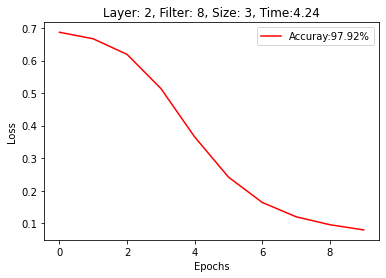

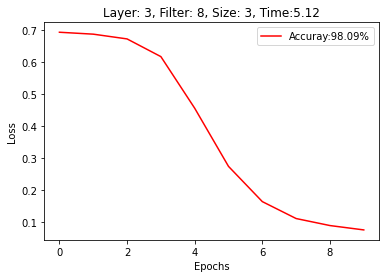

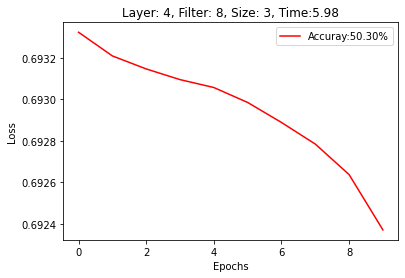

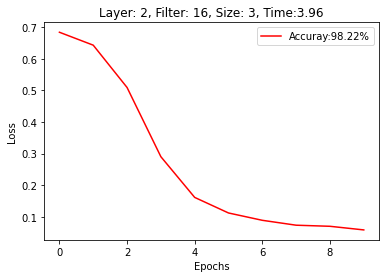

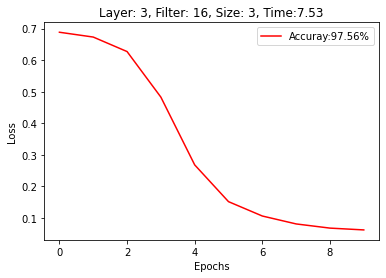

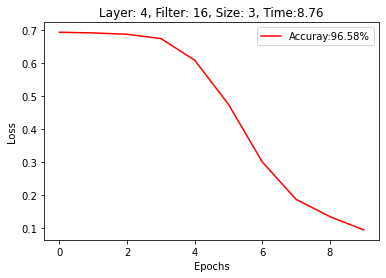

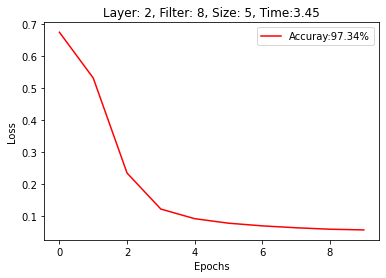

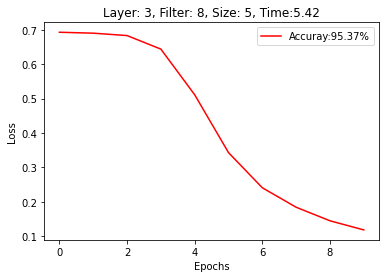

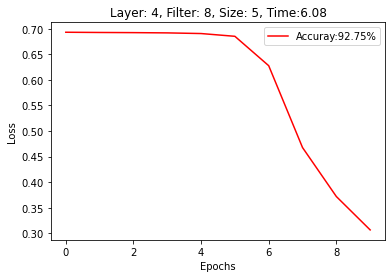

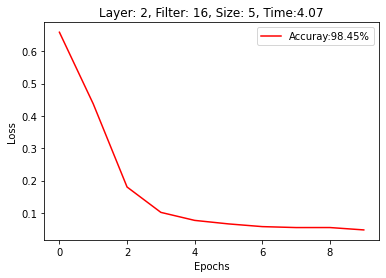

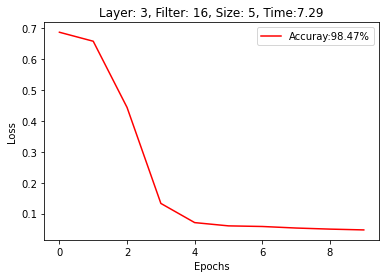

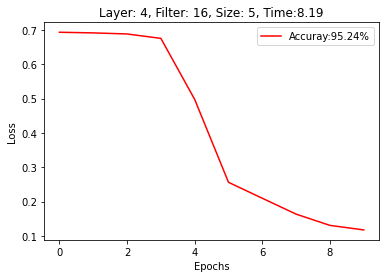

In [15]:
experiment(train_dataloader, test_dataloader)

As you can see from the above graphs, since all the models achieved 100% accuracy in the test dataset, it would be hard to decide which is the best model.<br>
Suppose that the dataset is 32x32 image, the model does not have to be large. Only 2 layers are needed to classify faces. Larger models take longer time to compute, so think it's better to use only 2 layers for the fitting model.<br>
To mention the number of filters, it seems that it does not show significant influence to such small dataset. So, in this case, using small number of filters takes less time.<br>
Finally, the size of the filter, the larger size takes less time. So using the larger filter would be recommended.<br>
<br>
For the best model, we picked using 2 layers, 8 filters, and 5x5 in the fileter size, is the best model.